In [195]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import log_loss, accuracy_score

In [196]:
data_path = './data/'
raw_train_df = pd.read_csv(data_path+'train.csv', index_col='PassengerId')
raw_test_df = pd.read_csv(data_path+'test.csv', index_col='PassengerId')

In [197]:
raw_train_df.info(), raw_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    f

(None, None)

In [198]:
# Define a custom estimator to extract the deck information from the cabin column
class ExtractNthLetter(BaseEstimator, TransformerMixin):
    def __init__(self, column, n_letters=1):
        self.column = column
        self.n_letters = n_letters

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["Deck"] = X[self.column].str[:self.n_letters]
        X.drop(columns=[self.column], inplace=True)
        return X

    def get_feature_names_out(self, input_features):
        return ["Deck"]

In [199]:
# Define a custom estimator to extract the title from the name
class ExtractTitleDropName(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["Title"] = X[self.column].apply(lambda name: name.split(',')[1].split('.')[0])
        X.drop(columns=[self.column], inplace=True)
        return X

    def get_feature_names_out(self, input_features):
        return ["Title"]

In [200]:
# Define a custom estimator to extract the title from the name
class FamilySizeEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["Family_size"] = X[self.columns].sum(axis=1) + 1
        return X

    def get_feature_names_out(self, input_features):
        return self.columns+["Family_size"]

In [201]:
# Pipelines
deck_pipeline = Pipeline([
    ('deck_extract', ExtractNthLetter(column='Cabin')),
    ('deck_encoder', OrdinalEncoder(encoded_missing_value=-1))
])

embarked_pipeline = Pipeline([
    ('embarked_imputer', SimpleImputer(strategy='most_frequent', copy=False)),
    ('embarked_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

sex_pipeline = Pipeline([
    ('sex_encoder', OrdinalEncoder(categories=[['female', 'male']], handle_unknown='use_encoded_value', unknown_value=-1))
])

age_pipeline = Pipeline([
    ('age_imputer', KNNImputer(n_neighbors=5))
])

fare_pipeline = Pipeline([
    ('fare_scaler', StandardScaler()),
    ('fare_imputer', SimpleImputer(strategy='median'))
])

name_pipeline = Pipeline([
    ('title_extractor', ExtractTitleDropName(column='Name')),
    ('title_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

family_pipeline = Pipeline([
    ('family_extractor', FamilySizeEncoder(columns=['SibSp','Parch']))
])

In [202]:
# Column Transformer
preprocessor = ColumnTransformer([
    ('fare', fare_pipeline, ['Fare']),                        # Standardize fare and impute with median
    ('deck', deck_pipeline, ['Cabin']),                       # Extract and encode deck info
    ('embarked', embarked_pipeline, ['Embarked']),            # One-hot-encode Embarked
    ('sex', sex_pipeline, ['Sex']),                           # Ordinal encode Sex
    ('name', name_pipeline, ['Name']),                        # Extract title from name
    ('family', family_pipeline, ['SibSp', 'Parch']),          # Use SibSp + Parch + 1 as proxy for family size
    ('age', age_pipeline, ['Age']),                           # Impute Age
], remainder='passthrough', verbose_feature_names_out=False,force_int_remainder_cols=False)

In [203]:
# Preprocess the data
train_df = preprocessor.fit_transform(raw_train_df)

# Convert to DataFrame with column names
train_df = pd.DataFrame(
    train_df,
    index=raw_train_df.index,
    columns=fitted_preprocessor.get_feature_names_out()
).convert_dtypes()

In [204]:
train_df.drop(columns=['Ticket','SibSp','Parch'], axis=1, inplace=True)

In [205]:
train_df.head()

Fare  Deck  Embarked  Sex  Title  Family_size   Age  \
PassengerId                                                            
1           -0.502445    -1         2    1     11            2  22.0   
2            0.786845     2         0    0     12            2  38.0   
3           -0.488854    -1         2    0      8            1  26.0   
4             0.42073     2         2    0     12            2  35.0   
5           -0.486337    -1         2    1     11            1  35.0   

             Survived  Pclass  
PassengerId                    
1                   0       3  
2                   1       1  
3                   1       3  
4                   1       1  
5                   0       3

<Axes: >

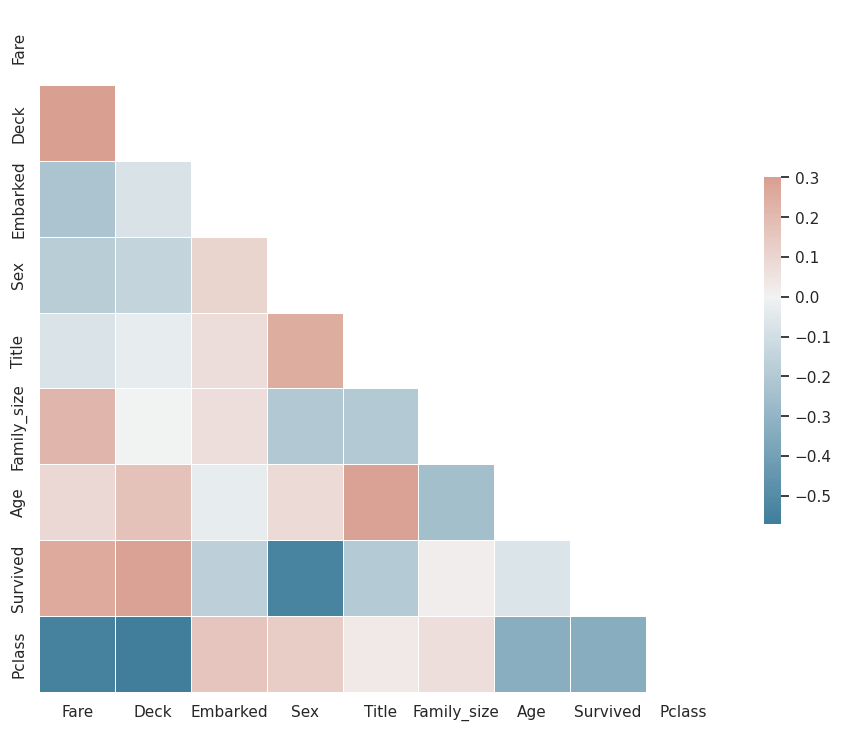

In [206]:
corr = train_df.select_dtypes(exclude=['string']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(230,20,as_cmap=True)
sns.heatmap(corr,
            mask = mask,
            cmap = cmap,
            vmax = .3,
            center = 0,
            square = True,
            linewidths= .5,
            cbar_kws = {'shrink': .5}
            )

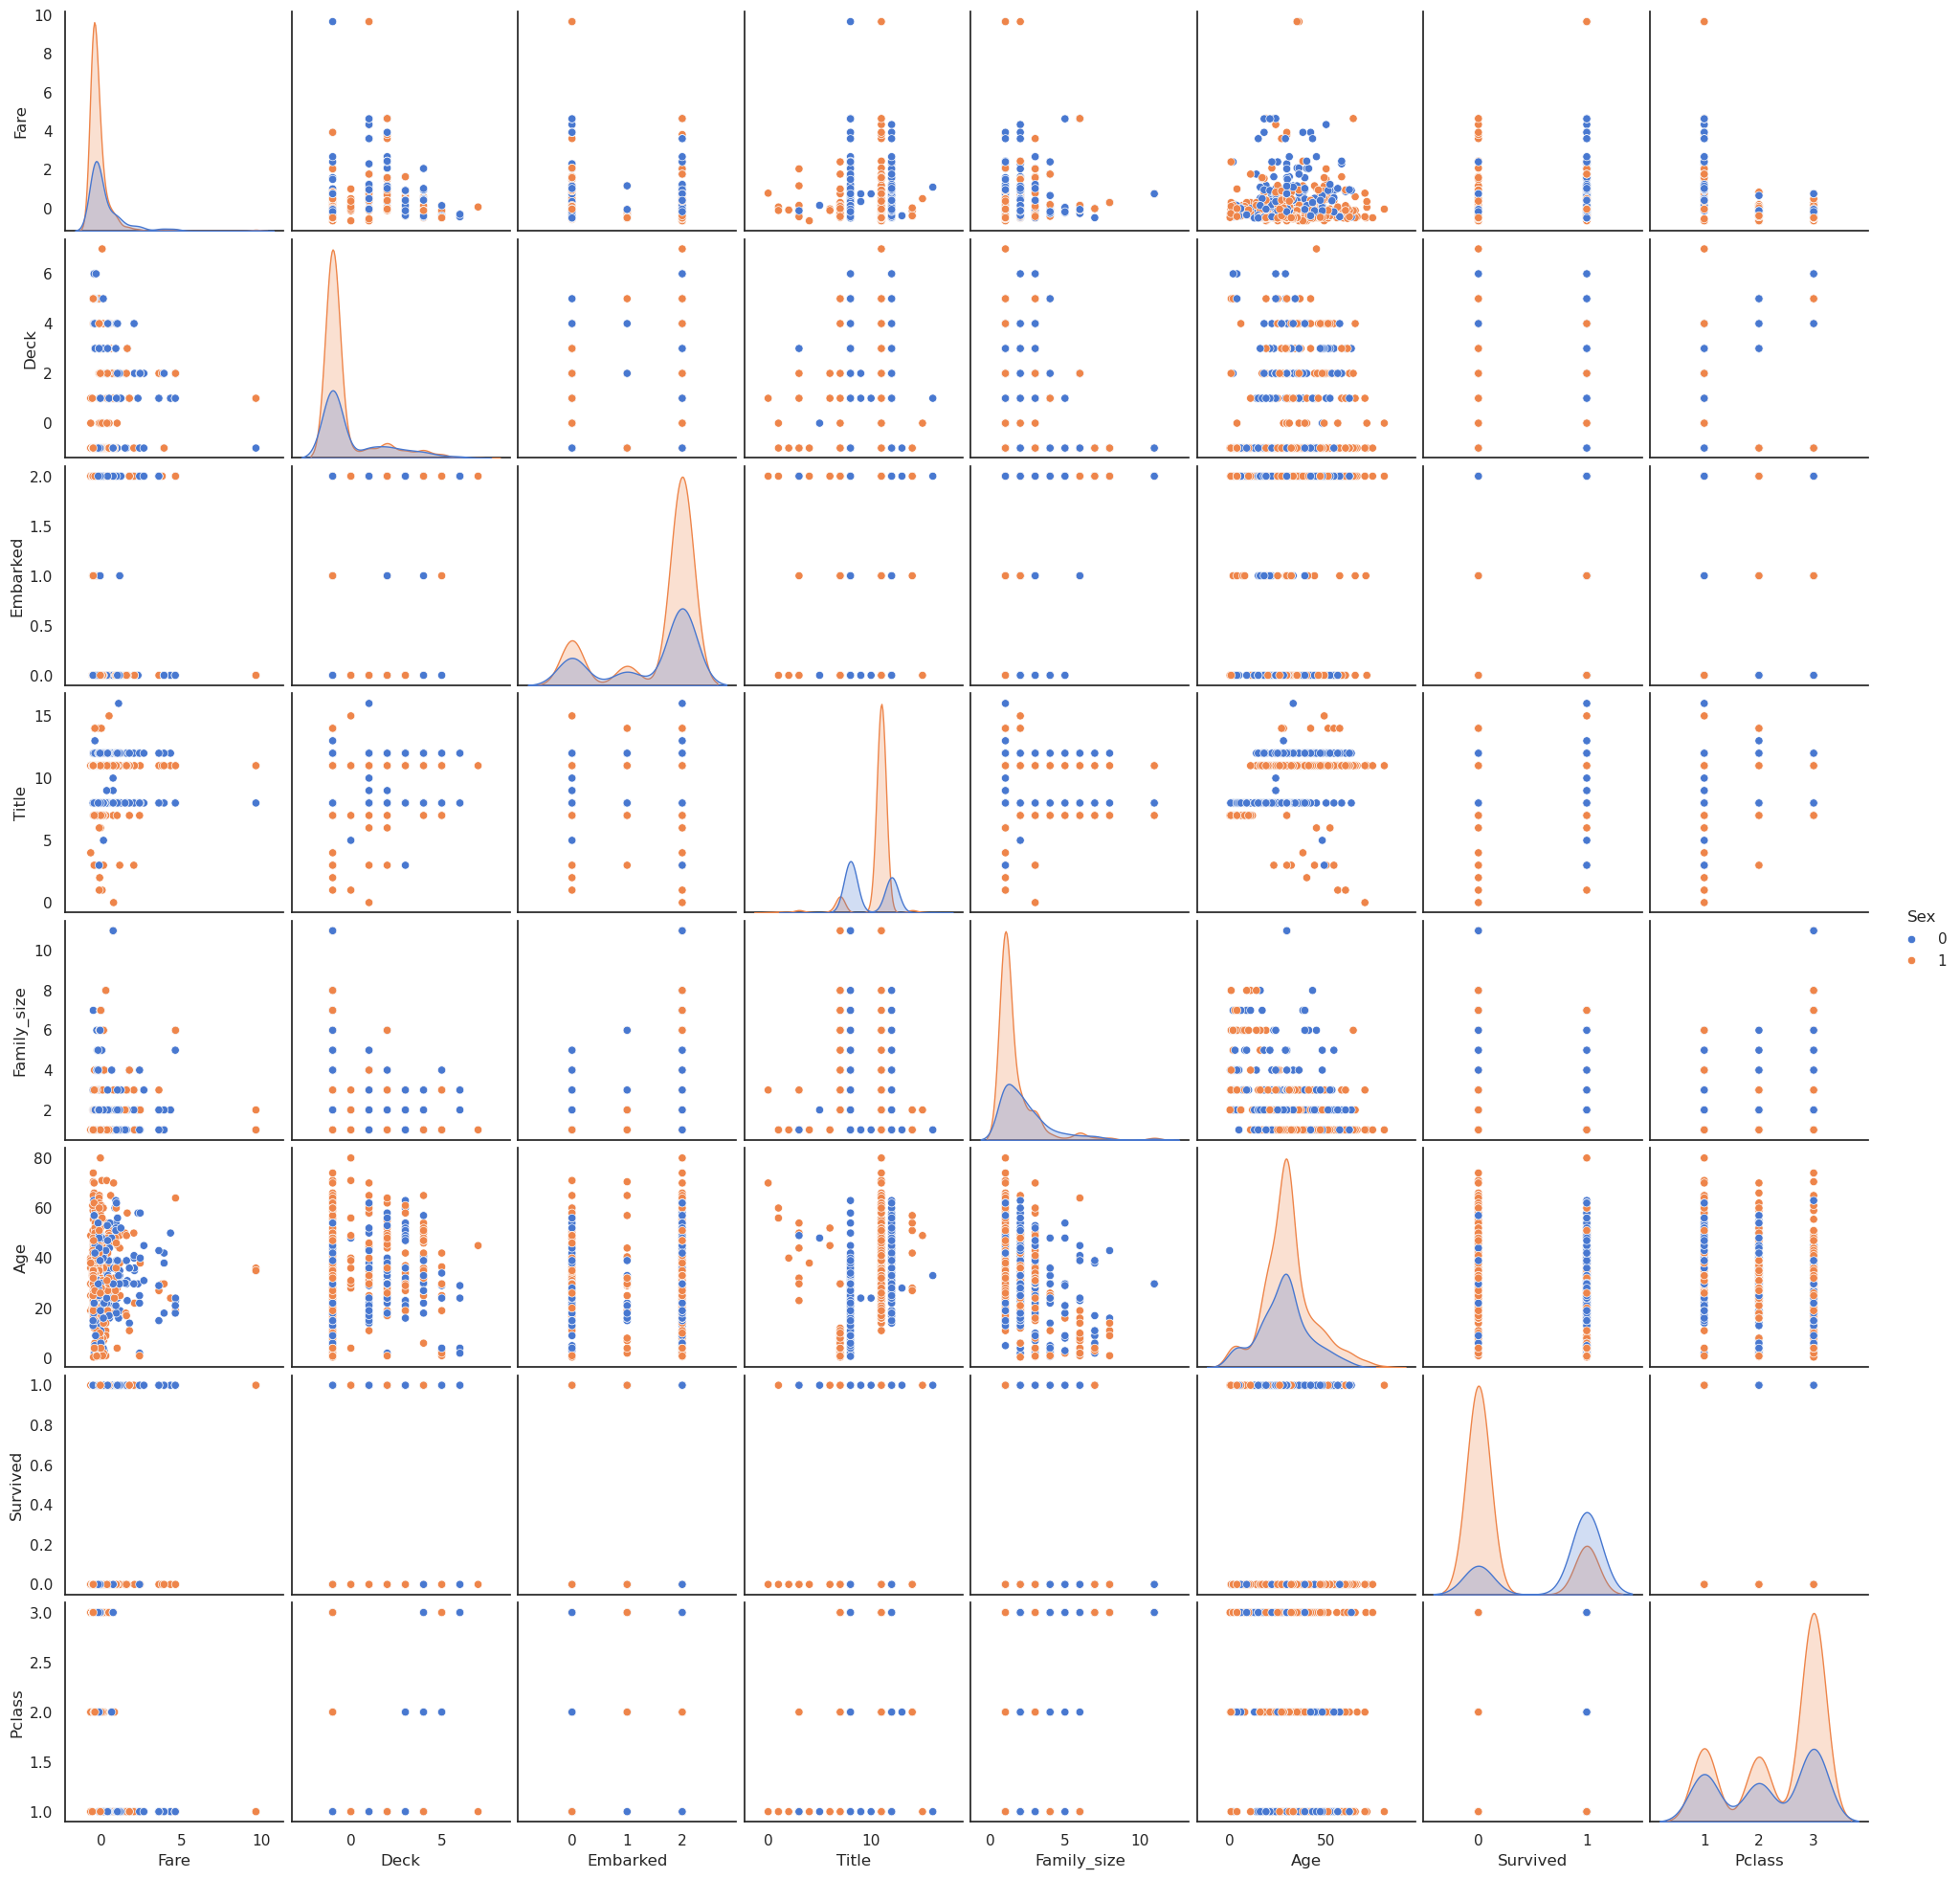

In [207]:
sns.pairplot(train_df, hue='Sex', palette='muted')

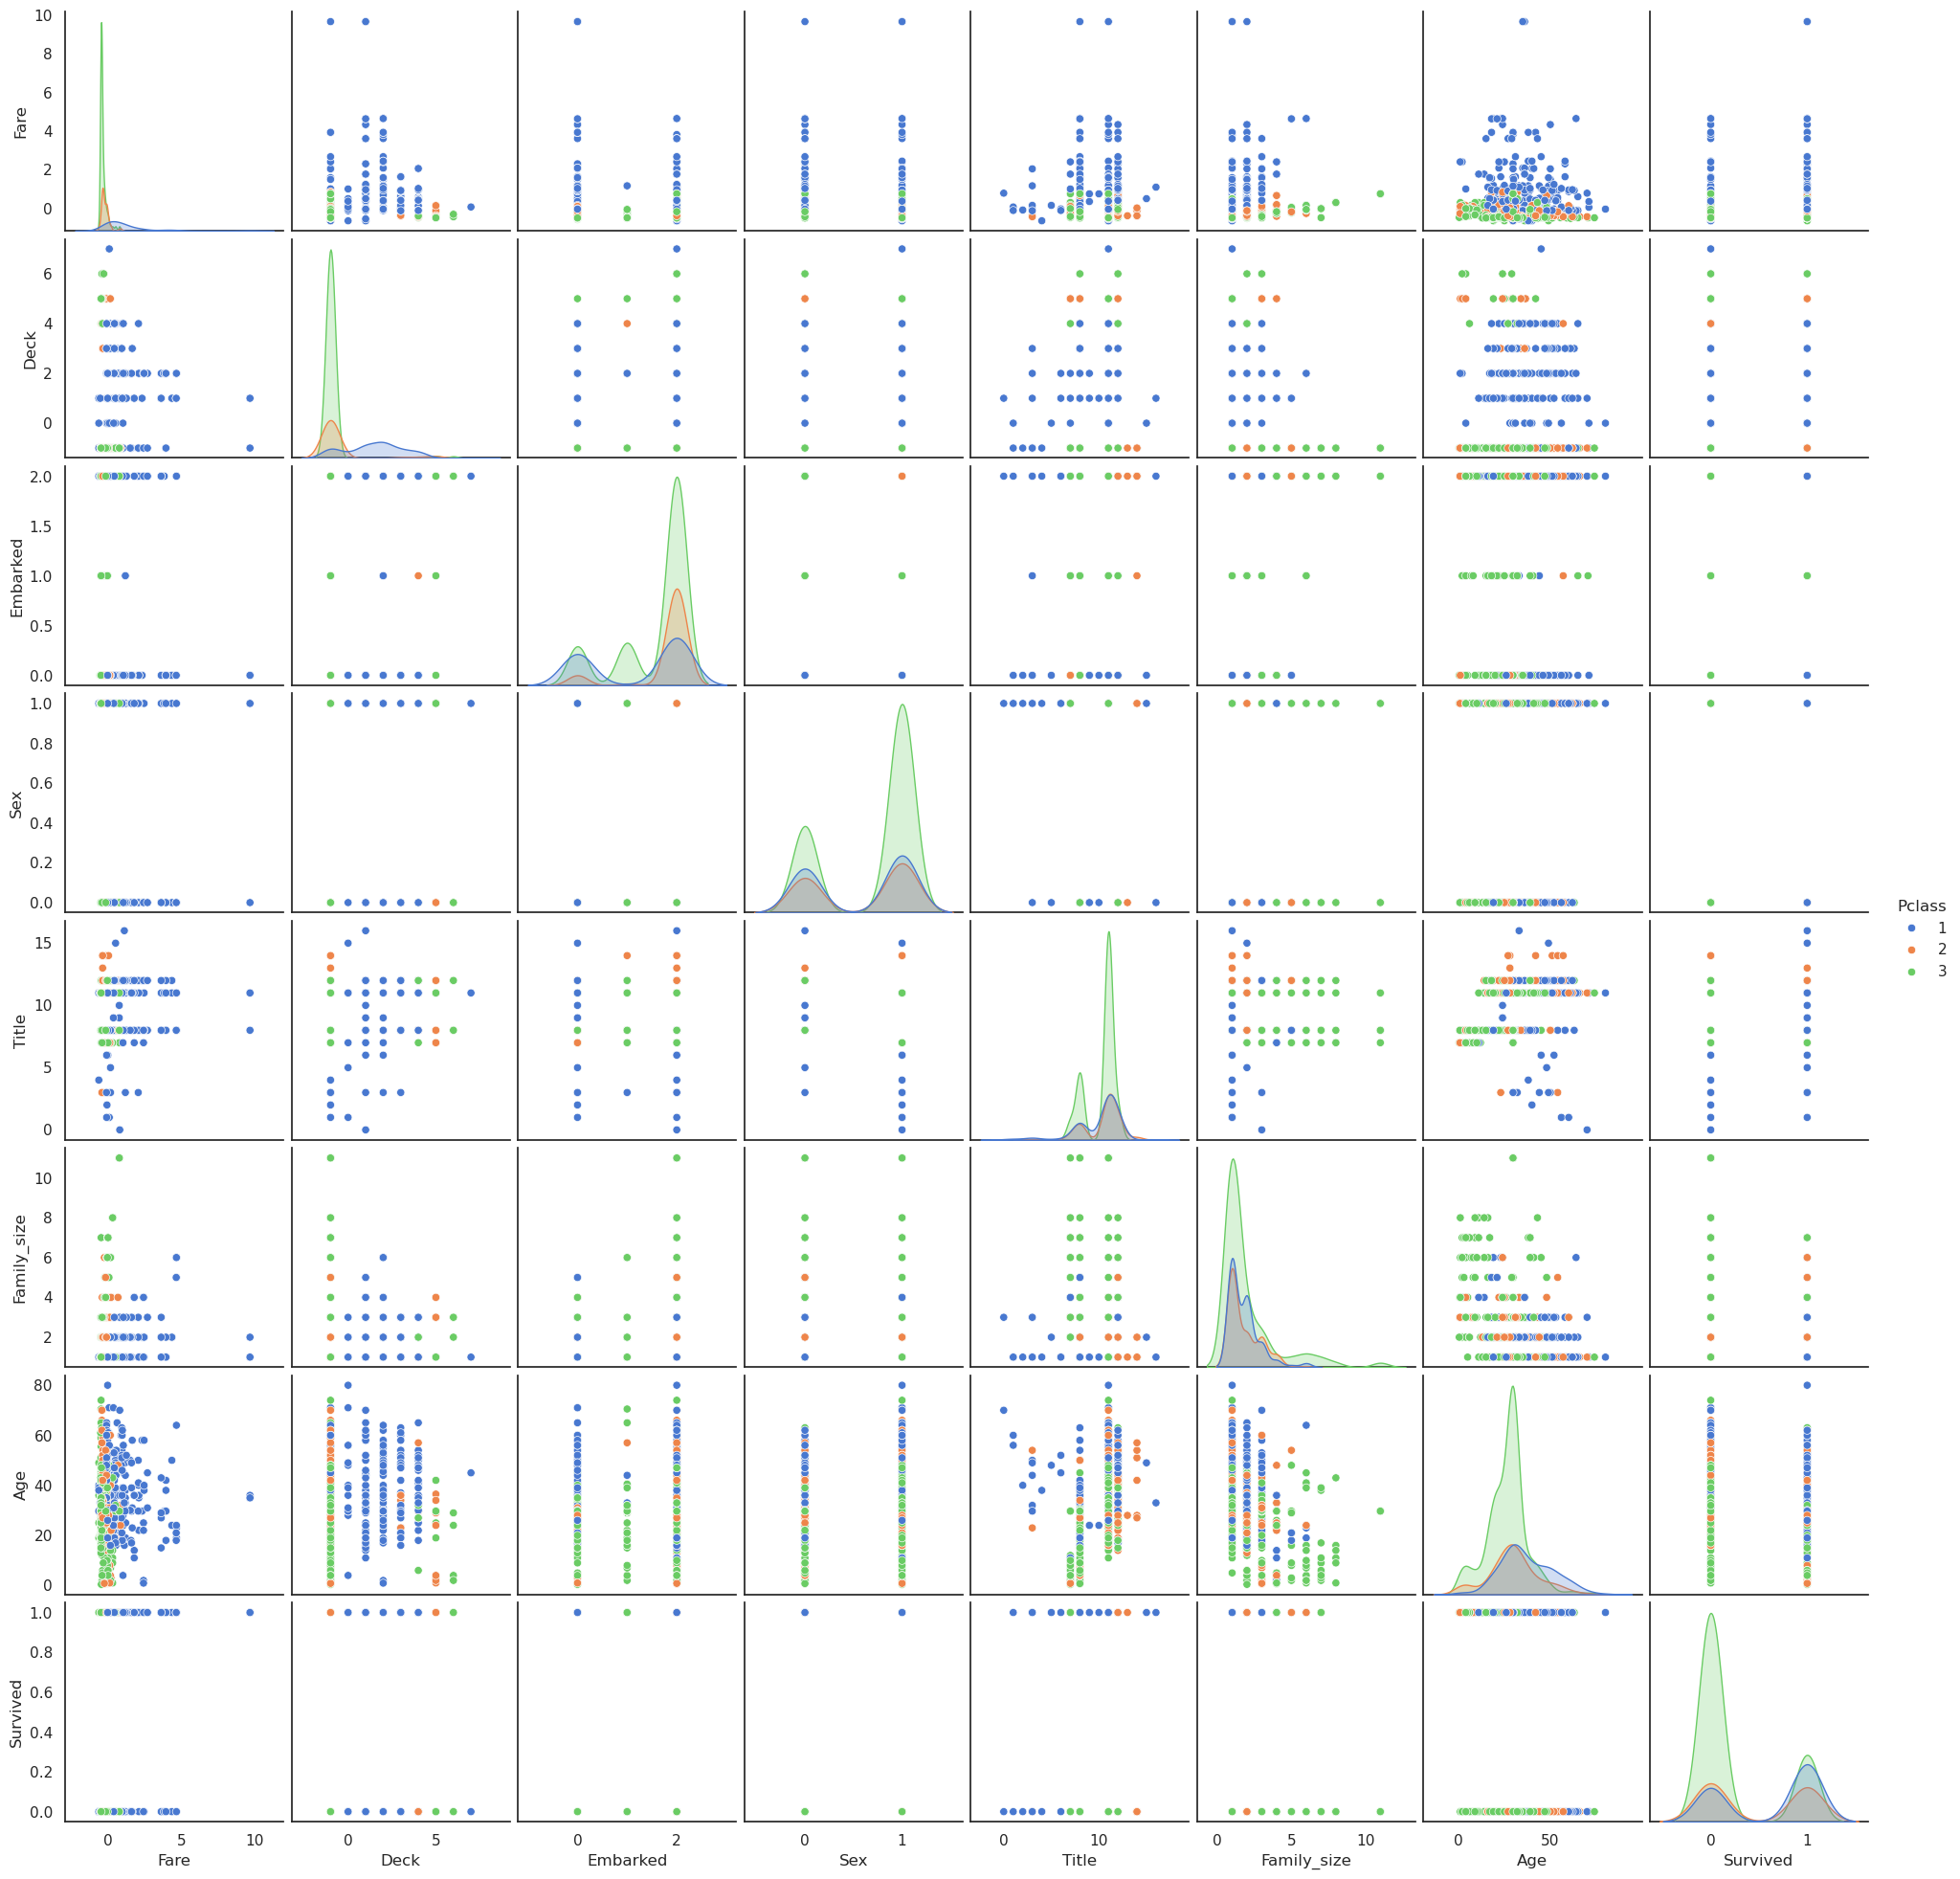

In [208]:
sns.pairplot(train_df, hue='Pclass', palette='muted')

In [209]:
sns.set_theme(style='white', palette='muted')
palette= sns.color_palette('muted')

f = plt.figure(figsize=(18,6), dpi=1600)
gs = f.add_gridspec(nrows=2, ncols=3, hspace=.5)

sns.countplot(data=train_df, x='Survived', ax=f.add_subplot(gs[0,0]), color=palette[0])
plt.title('Distribution of survival');

sns.countplot(data=train_df, y='Pclass', ax=f.add_subplot(gs[0,1]), color=palette[0])
plt.title("Class Distribution");

sns.histplot(data=train_df, x='Age', hue='Survived', palette='muted', multiple='fill', bins=25, element='step', ax=f.add_subplot(gs[0,2]))
plt.xlabel('Age');
plt.title('Survival Distribution by Age');

sns.kdeplot(data=train_df,x='Age',hue='Pclass', palette='muted', multiple='fill', ax=f.add_subplot(gs[1,0:2]))
plt.xlabel("Age");
plt.title("Age Distribution by classes");

sns.violinplot(data=train_df, x='Survived', y='Age', hue='Sex', palette='muted', split=True, ax=f.add_subplot(gs[1,2]))
plt.title('Age Distribution by Survival and Sex');
plt.xlabel('Survived'); plt.ylabel('Age');

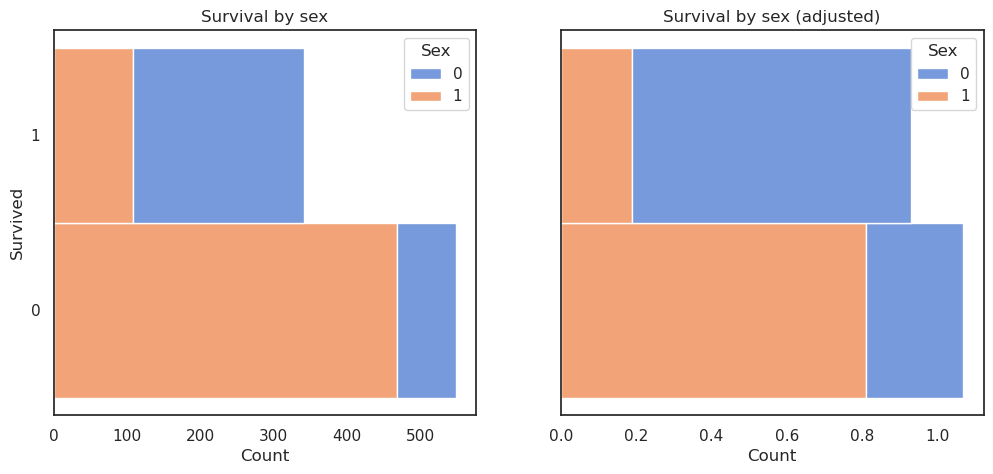

In [210]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharey=True)

plt.yticks([0,1])
hist1 = sns.histplot(data=train_df, y='Survived', discrete=True, hue='Sex', multiple='stack', ax=ax[0])
hist1.set_title('Survival by sex');
hist1.set_yticks([0,1]);

# Adjust the survival rates accounting for the discrepancy between males and females aboard
sex_counts = train_df['Sex'].value_counts()
survival_counts = train_df.groupby(['Sex','Survived']).size()
survival_rates = survival_counts / sex_counts
survival_rates = survival_rates.reset_index(name = 'Proportion')
hist2 = sns.histplot(data=survival_rates, y='Survived', weights='Proportion', discrete=True, hue='Sex', multiple='stack', ax=ax[1])
hist2.set_title('Survival by sex (adjusted)');

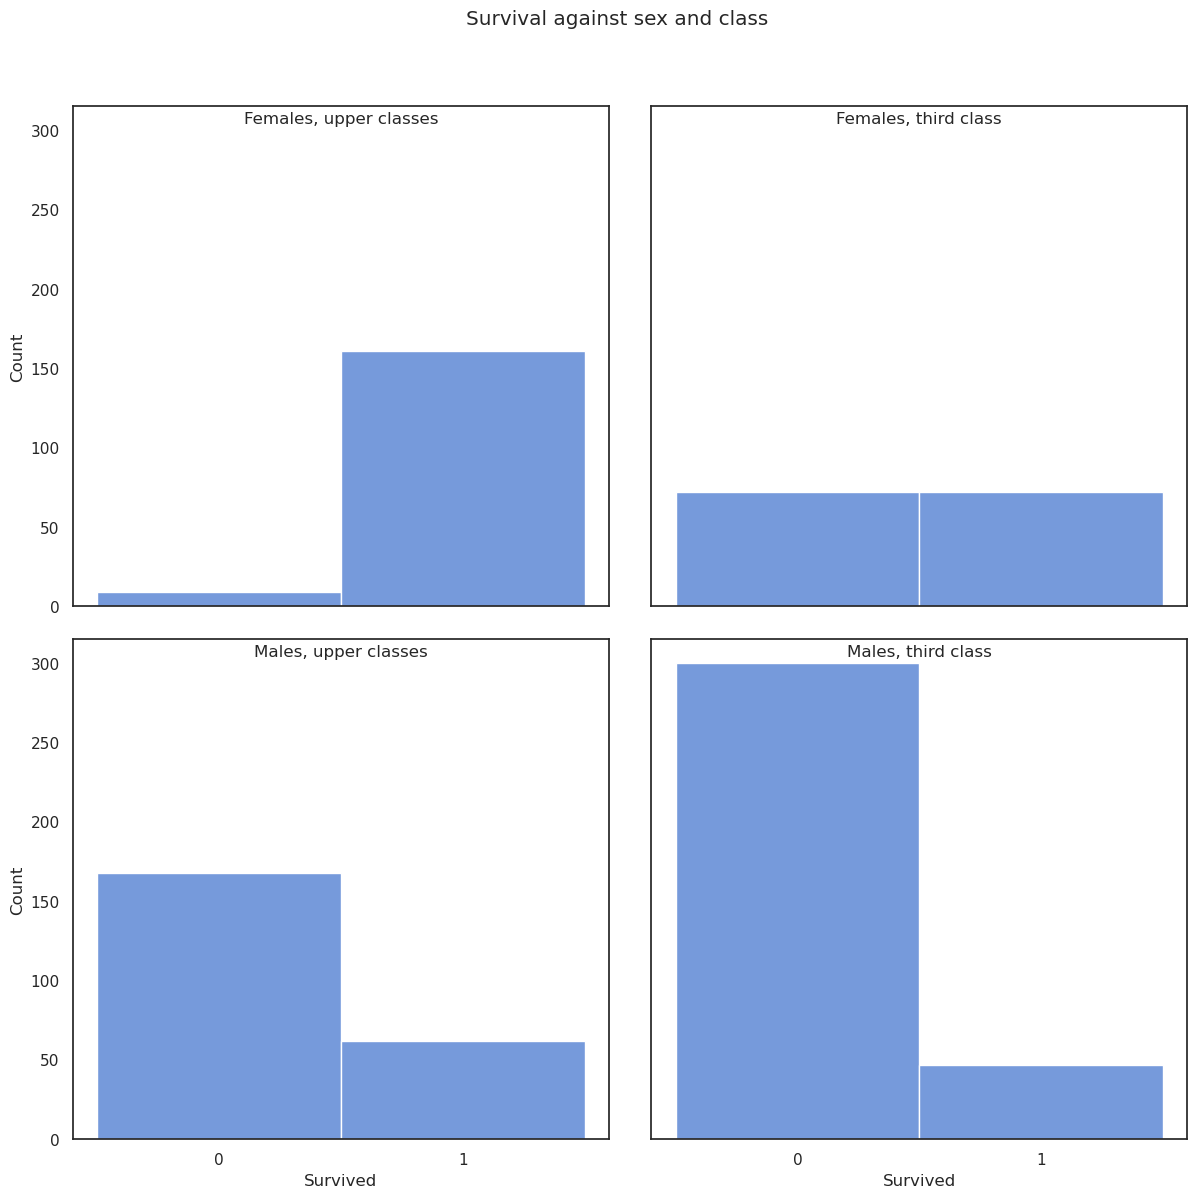

In [211]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12), sharey=True, sharex=True)
fig.suptitle('Survival against sex and class')
fig.tight_layout(rect=[0, 0, 1, 0.95])
sns.histplot(train_df[(train_df['Sex'] == 0) & ((train_df['Pclass'] == 1) | (train_df['Pclass']==2))], discrete=True, x='Survived', ax = ax[0,0])
ax[0,0].set_title('Females, upper classes', loc='center', y=.95);
ax[0,0].set_xticks([0,1]);
sns.histplot(train_df[(train_df['Sex'] == 0) & (train_df['Pclass'] == 3)], discrete=True, x='Survived', ax = ax[0,1])
ax[0,1].set_title('Females, third class', loc='center', y=.95);
sns.histplot(train_df[(train_df['Sex'] == 1) & ((train_df['Pclass'] == 1) | (train_df['Pclass']==2))], discrete=True, x='Survived', ax = ax[1,0])
ax[1,0].set_title('Males, upper classes', loc='center', y=.95);
sns.histplot(train_df[(train_df['Sex'] == 1) & (train_df['Pclass'] == 3)], discrete=True, x='Survived', ax = ax[1,1])
ax[1,1].set_title('Males, third class', loc='center', y=.95);

In [212]:
# Export the preprocessed dataframe for classification purposes
train_df.to_csv(data_path+'train_preprocessed_new.csv',index=False)

<Axes: xlabel='Fare', ylabel='Age'>

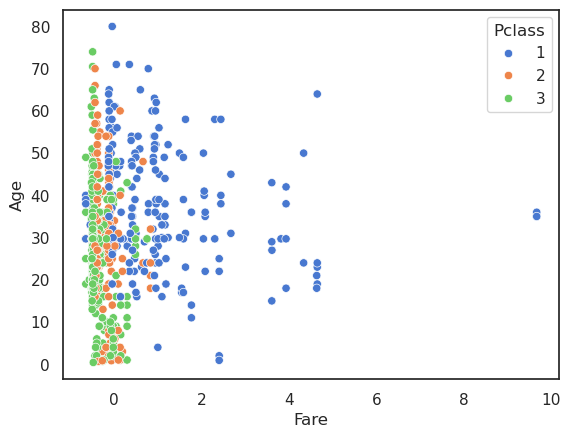

In [213]:
sns.scatterplot(data=train_df,x='Fare',y='Age',hue='Pclass',palette='muted')

In [214]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [215]:
models = {
    'Logistic': LogisticRegressionCV(Cs=20, cv=2, penalty='l2', scoring='neg_log_loss', max_iter=5000, n_jobs=-1, random_state=0),
    'DecisionTree': DecisionTreeClassifier(criterion='log_loss', max_depth=5, random_state=0),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0, criterion='log_loss'),
    'SVM': SVC(kernel='linear',C=10,gamma=.000001)
}

In [216]:
n_iter, acc_score = 10, {model: 0 for model in models}

for n in range(n_iter):
    train_X, test_X, train_y, test_y = train_test_split(train_df.drop(columns='Survived',axis=1), train_df['Survived'], train_size=.7, shuffle=True)
    for model in models.keys():
        models[model].fit(X=train_X, y=train_y)
        pred = models[model].predict(test_X)
        acc_score[model] += accuracy_score(y_true=test_y, y_pred=pred)

acc_score = {model: value/10 for (model, value) in acc_score.items()}

In [232]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100,oob_score=True)
scores = cross_val_score(rf, train_df.drop(columns='Survived'), train_df['Survived'], cv=5, scoring = "accuracy")
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Mean: 0.8148201619484026
Standard Deviation: 0.030528833712770834


In [240]:
from sklearn.model_selection import GridSearchCV

param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10,], "min_samples_split" : [2, 4, 10,], "n_estimators": [100,500,11000,1500]}
gd=GridSearchCV(estimator=RandomForestClassifier(random_state=42),param_grid=param_grid,verbose=True,n_jobs=16)
gd.fit(X=train_df.drop(columns=['Survived']), y=train_df['Survived'])


Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=16,
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 4, 10],
                         'n_estimators': [100, 500, 11000, 1500]},
             verbose=True)

In [242]:
print(gd.best_params_,gd.best_score_)

{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 11000} 0.8338961772644531


In [244]:
random_forest_tuned = RandomForestClassifier(criterion='entropy',
                                             min_samples_leaf=1,
                                             min_samples_split=10,
                                             n_estimators=11000,
                                             max_depth=7,
                                             oob_score=True,
                                             n_jobs=16,
                                             verbose=True)
random_forest_tuned.fit(train_X,train_y)
random_forest_tuned.score(test_X,test_y)
print('oob score: ',round(random_forest_tuned.oob_score_,4)*100,'%')

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.6s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    2.5s
[Parallel(n_jobs=16)]: Done 1768 tasks      | elapsed:    3.5s
[Parallel(n_jobs=16)]: Done 2418 tasks      | elapsed:    4.8s
[Parallel(n_jobs=16)]: Done 3168 tasks      | elapsed:    6.4s
[Parallel(n_jobs=16)]: Done 4018 tasks      | elapsed:    8.1s
[Parallel(n_jobs=16)]: Done 4968 tasks      | elapsed:    9.9s
[Parallel(n_jobs=16)]: Done 6018 tasks      | elapsed:   12.0s
[Parallel(n_jobs=16)]: Done 7168 tasks      | elapsed:   14.3s
[Parallel(n_jobs=16)]: Done 8418 tasks      | elapsed:   16.8s
[Parallel(n_jobs=16)]: Done 9768 tasks      | elapsed:   21.0s
[Parallel(n_jobs=16)]: Done 11000 out of

oob score:  82.83 %


[Parallel(n_jobs=16)]: Done 11000 out of 11000 | elapsed:    4.4s finished
